ADD DOCUMENTATION

In [12]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage, TextArea, HPacker
import time
from datetime import datetime
from PIL import Image
import numpy as np
import seaborn as sns

top_n_coins_input = 2 # Number of top coins to fetch, based on market cap, you can change this value

In [13]:
top_n_coins = min(50, max(1, top_n_coins_input)) # Limit to 50 coins
url = "https://api.coingecko.com/api/v3/coins/markets" # CoinGecko public API, no API key required but rate-limited so higher amount of requests will take longer
params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": top_n_coins,
    "page": 1,
}

response = requests.get(url, params=params)
top_coins = response.json()

print(f"Top {top_n_coins} cryptocurrencies by market cap:")
for i, coin in enumerate(top_coins):
    print(f"{i + 1}: {coin["name"]} ({coin["symbol"].upper()})")
    print(f"   Market Cap: ${coin["market_cap"]:,}")
    print(f"   Current Price: ${coin["current_price"]:,}")

Top 2 cryptocurrencies by market cap:
1: Bitcoin (BTC)
   Market Cap: $1,843,472,060,598
   Current Price: $92,828
2: Ethereum (ETH)
   Market Cap: $213,528,564,099
   Current Price: $1,770.54


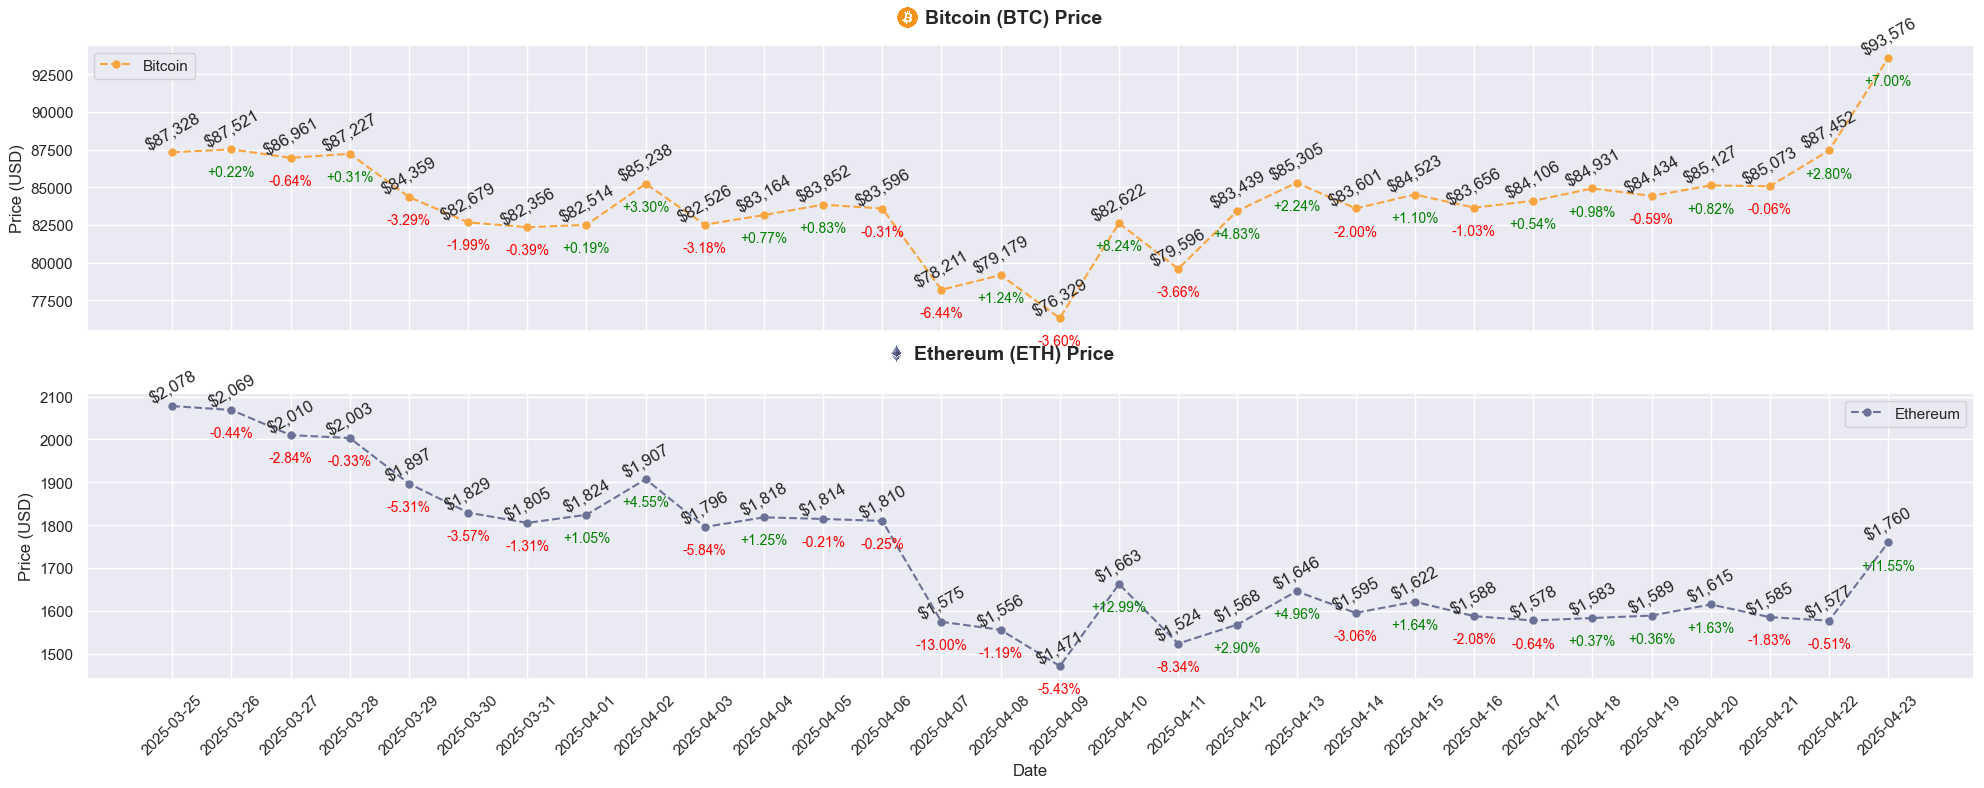

In [44]:
list_for_dataframe = []
coin_logos = {}
coin_colors = {}
logos_directory = "logos"
os.makedirs(logos_directory, exist_ok=True)

if top_n_coins > 20:
    print("Note: Loading more than 20 coins may take a while due to API limits.")

def get_dominant_color(image_path):
    img = Image.open(image_path).convert("RGBA")
    img = img.resize((50, 50))  # Resize to reduce noise
    img_np = np.array(img)
    
    # Remove fully transparent pixels
    pixels = img_np.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]  # Keep only non-transparent pixels

    rgb_pixels = pixels[:, :3]
    avg_color = tuple(np.mean(rgb_pixels, axis=0).astype(int))
    
    return tuple(c/255 for c in avg_color)  # Normalize to 0–1 for matplotlib

def get_logo(coin):
    logo_data = requests.get(coin["image"]).content
    logo_path = os.path.join(logos_directory, f"{coin["id"]}.png")
    with open(logo_path, "wb") as f:
        f.write(logo_data)
    logo_img = mpimg.imread(logo_path)
    coin_logos[coin["name"]] = logo_img
    coin_colors[coin["name"]] = get_dominant_color(logo_path)




# for coin in top_coins:
#     retries = 0
    
#     get_logo(coin) # Fetch and save the logo
    
#     params = {
#         "vs_currency": "usd",
#         "days": "30",
#         "interval": "daily",
#     }
#     url = f"https://api.coingecko.com/api/v3/coins/{coin['id']}/market_chart"
    
#     while retries < 3:
#         try:
#             response = requests.get(url, params=params, timeout=10)
#             response.raise_for_status()
#             data = response.json()

#             if "prices" not in data:
#                 raise ValueError(f"No 'prices' in response: {data}")

#             seen_dates = set()

#             for day in data["prices"]:
#                 timestamp, price = day
#                 date_str = datetime.fromtimestamp(timestamp / 1000).strftime("%Y-%m-%d")
#                 if date_str not in seen_dates:
#                     list_for_dataframe.append({
#                         "name": coin["name"],
#                         "symbol": coin["symbol"].upper(),
#                         "date": date_str,
#                         "price": price,
#                     })
#                     seen_dates.add(date_str)
#             break
#         except Exception as e:
#             retries += 1
#             print(f"Error fetching data for {coin["name"]}: {e}")
#             if retries < 3:
#                 print(f"Retrying in 30 seconds... (attempt {retries}/3)")
#                 time.sleep(30)
#             else:
#                 print(f"❌ Failed to fetch data for {coin["name"]} after 3 attempts.")
    
# df = pd.DataFrame(list_for_dataframe)

df = pd.read_csv("test_csv.csv")  # Load the CSV file
for coin in top_coins:
    get_logo(coin)

sns.set_theme(style="darkgrid")

grouped = df.groupby("name")["price"]
mean_prices = grouped.mean()
std_prices = grouped.std()

# Calculate coefficient of variation (CV)
cv = std_prices / mean_prices

low_volatility_names = cv[cv < 0.01].index
df = df[~df["name"].isin(low_volatility_names)]
for name in low_volatility_names:
    print(f"Low volatility coin removed: {name}")
    
unique_names = df["name"].unique()

fig, axes = plt.subplots(len(unique_names), 1, figsize=(20, 4 * len(unique_names)), sharex=True)

if len(unique_names) == 1:
    axes = [axes]  # Make it iterable if only 1 axis

for ax, name in zip(axes, unique_names):
    color = coin_colors.get(name, "blue")
    group = df[df["name"] == name].copy()
    group["pct_change"] = group["price"].pct_change() * 100

    ax.plot(group["date"], group["price"], "o--", label=name, color=color, linewidth=1.5, markersize=5)

    for x, y, pct in zip(group["date"], group["price"], group["pct_change"]):
        if y > 50: # Use integer format for prices above $50
            price_label = f"${y:,.0f}"
        else:
            price_label = f"${y:,.2f}"
        ax.text(x, y, price_label, fontsize=12, ha="center", va="bottom", rotation=30)

        if not pd.isna(pct):
            pct_label = f"{pct:+.2f}%"  # includes + or - sign
            color = "green" if pct > 0 else "red" if pct < 0 else "gray"
            ax.text(x, y, f"\n{pct_label}", fontsize=10, color=color,
                    ha="center", va="top", rotation=0)
    
    symbol = group["symbol"].iloc[0]
    title_text = f"{name} ({symbol}) Price"

    # Create the combined logo + title
    if name in coin_logos:
        logo_img = coin_logos[name]
        imagebox = OffsetImage(logo_img, zoom=0.06)
        textbox = TextArea(title_text, textprops=dict(fontsize=14, weight="bold"))
        
        vbox = HPacker(children=[imagebox, textbox], align="center", pad=0, sep=5)
        ab = AnnotationBbox(
            vbox,
            (0.5, ax.get_position().y1 + 0.07),  # place above the subplot
            xycoords="figure fraction",
            frameon=False,
            box_alignment=(0.5, 0)
        )
        fig.add_artist(ab)
    else:
        # Fallback to just title if logo is missing
        fig.text(0.5, ax.get_position().y1 + 0.05, title_text,
                ha="center", va="bottom", fontsize=14, weight="bold")
    
    ax.set_ylabel("Price (USD)")
    ax.legend()

plt.xticks(rotation=45)
plt.xlabel("Date")

plt.tight_layout()
plt.show()